## Libraries to be used

In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
d = "./drive/MyDrive/prev_input.csv" # dataset
q = "./drive/MyDrive/query_nasdaq2007_17.csv" # queryset
od = "/content/input.csv" # output_dataset_file
oq = "/content/query.csv" # output_query_file

## Plotting functions from the article

In [4]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, 50, 10))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)

def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

## Create Dataframes

*   Combine the input and query dataframes
*   We use the last 20% of time series for testing

In [83]:
df=pd.read_csv(d, delimiter='\t', header=None)
df_query=pd.read_csv(q, delimiter='\t', header=None)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (348, 3651)


In [84]:
query_file_legnth = len(df_query)
df = df.append(df_query, ignore_index = True)

In [85]:
test_samples = int(0.2 * df.shape[0])

In [86]:
df_test = df[-test_samples:]
df.drop(df.tail(test_samples).index,inplace=True)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (288, 3651)


## Hyperparameters

In [9]:
window_length = 50
encoding_dim = 3
epochs = 5

## Create Datasets

We do the following for training as well as the testing dataframe:
1.   Normalize all time series, each curve has its own scaler
2.   Separate each curve into curve_length/window pieces (each curve piece is length window, in our case it's 50)
3.   Merge all time series



In [10]:
train_scalers = []
normalized_curves = []

for j in range (0,len(df)):
  scaler = MinMaxScaler()
  normalized_curves.append(scaler.fit_transform(df.iloc[j, 1:].values.reshape(-1, 1)))
  train_scalers.append(scaler)

In [11]:
for j in range (0,len(df)):
  x_train = np.array([normalized_curves[j][i:i+window_length] for i in range(0, len(normalized_curves[j][:]), window_length)])

  if(j>0):
    allArrays = np.concatenate([allArrays, x_train])
  elif(j==0):
    allArrays = x_train

In [12]:
test_scalers = []
normalized_curves = []

for j in range (0,len(df_test)):
  scaler = MinMaxScaler()
  normalized_curves.append(scaler.fit_transform(df_test.iloc[j, 1:].values.reshape(-1, 1)))
  test_scalers.append(scaler)

In [13]:
for k in range (0,len(df_test)):
  x_test = np.array([normalized_curves[k][i:i+window_length] for i in range(0, len(normalized_curves[k][:]), window_length)])

  if(k>0):
    allArrays2 = np.concatenate([allArrays2, x_test])
  elif(k==0):
    allArrays2 = x_test

In [14]:
x_train = allArrays.astype('float32')
x_test = allArrays2.astype('float32')
curve = np.concatenate([x_train, x_test])

## Load the Pre-trained Models

In [ ]:
!unzip /content/exercise_c_encoder.zip
!unzip /content/exercise_c_decoder.zip

In [ ]:
encoder = tf.keras.models.load_model("/content/content/exercise_c_encoder")
autoencoder = tf.keras.models.load_model("/content/content/exercise_c_decoder")

## Train the Model

In [ ]:
input_window = Input(shape=(window_length,1))

x = Conv1D(16, encoding_dim, activation="relu", padding="same")(input_window) # 10 dims
x = MaxPooling1D(2, padding="same")(x) # 5 dims

x = MaxPooling1D(2, padding="same")(x) # 5 dims

x = Conv1D(1, encoding_dim, activation="relu", padding="same")(x) # 5 dims
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

x = Conv1D(16, encoding_dim, activation="relu", padding="same")(encoded) # 3 dims
x = UpSampling1D(2)(x) # 6 dims

x = Conv1D(16, 2, activation='relu')(x) # 5 dims
x = UpSampling1D(2)(x) # 10 dims

x = Conv1D(4, 2, activation='relu')(x) # 5 dims
x = UpSampling1D(2)(x) # 10 dims

decoded = Conv1D(1, encoding_dim, activation='tanh', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
# autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
657/657 [==============================] - 5s 6ms/step - loss: 0.5944 - val_loss: 0.5142
Epoch 2/5
657/657 [==============================] - 4s 6ms/step - loss: 0.5074 - val_loss: 0.5114
Epoch 3/5
657/657 [==============================] - 4s 6ms/step - loss: 0.5058 - val_loss: 0.5107
Epoch 4/5
657/657 [==============================] - 4s 6ms/step - loss: 0.5051 - val_loss: 0.5103
Epoch 5/5
657/657 [==============================] - 4s 6ms/step - loss: 0.5048 - val_loss: 0.5100


In [ ]:
# encoder.save("exercise_c_encoder")
# autoencoder.save("exercise_c_decoder")

In [ ]:
from google.colab import files
# !unzip /content/exercise_b.zip
!zip -r /content/exercise_c_encoder.zip /content/exercise_c_encoder
!zip -r /content/exercise_c_decoder.zip /content/exercise_c_decoder
# files.download("/content/exercise_b")

## Predict Decoded test time series

In [ ]:
decoded_stocks = autoencoder.predict(x_test)

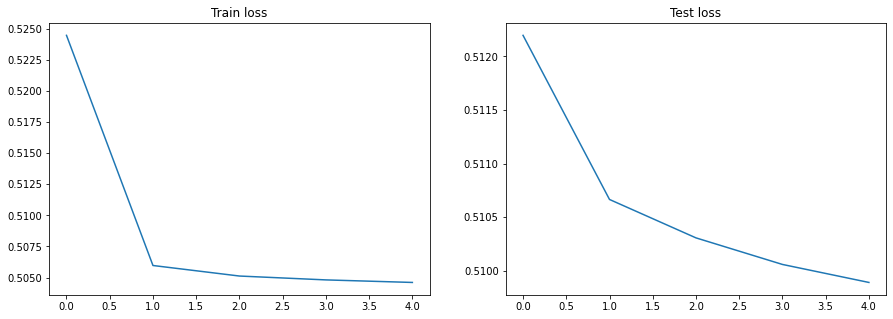

In [ ]:
plot_history(history)

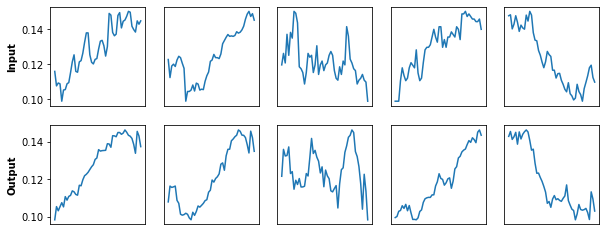

In [ ]:
plot_examples(x_test, decoded_stocks)

## Inverse transform all decoded time series

In [ ]:
decoded_time_series = decoded_stocks.reshape(-1,1)

In [ ]:
normalized_curves = []
curve_length = int(len(decoded_time_series)/len(df_test))

for j in range(0,len(df_test)):
  normalized_curves.append(test_scalers[j].inverse_transform(decoded_time_series[j*curve_length:j*curve_length + curve_length]))

In [ ]:
decoded_time_series = np.array(normalized_curves)

**Comparing the first decoded curve with the real one**

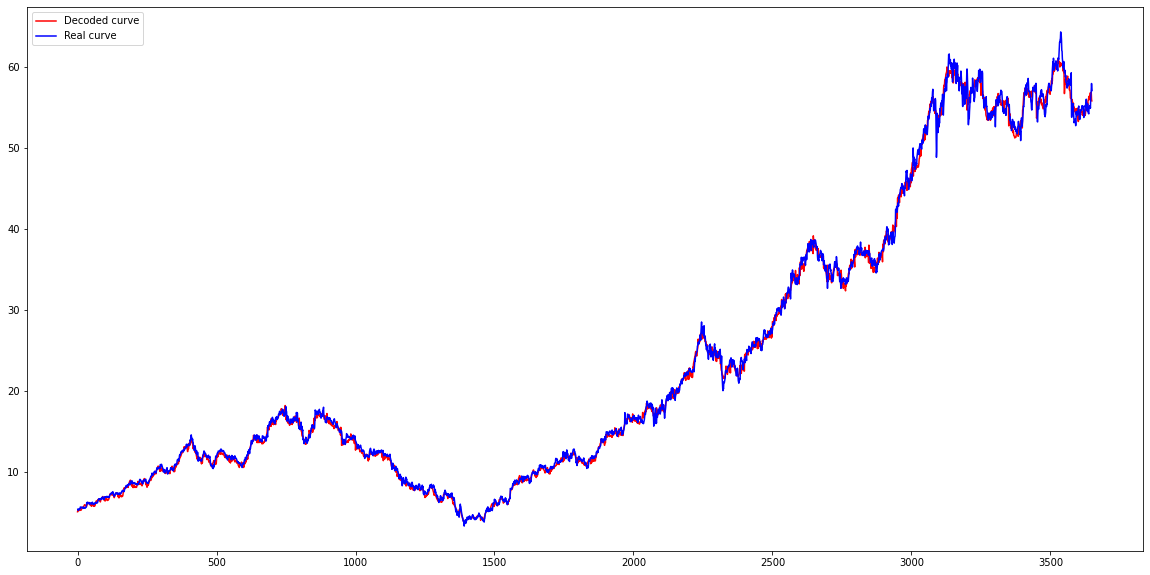

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(decoded_time_series[1, :], color = 'red', label = 'Decoded curve')
plt.plot(df_test.iloc[1, 1:], color = 'blue', label = 'Real curve')
plt.legend()
plt.show()

## Predict all Encoded time series

In [91]:
encoded_ = encoder.predict(curve)

In [92]:
encoded_.shape

(26207, 7, 1)

In [93]:
wind = encoded_.shape[1]

### Remove the noice mentioned in the report

In [94]:
if wind > 5:
  true_array = []
  for i in range(0, len(encoded_)): 
    true_array.append(encoded_[i][1:wind-1])

  encoded_ = np.array(true_array)

In [95]:
encoded_ = encoded_.reshape(-1,1)

In [ ]:
# scalers = train_scalers + test_scalers

In [96]:
# normalized_curves = []
curve_length = int(len(encoded_)/(len(df)+len(df_test)))
# curve_length = int(curve_length - curve_length/wind)

# for j in range(0,len(df)+len(df_test)):
#   normalized_curves.append(scalers[j].inverse_transform(encoded_[j*curve_length:j*curve_length + curve_length]))

In [ ]:
# encoded_ = np.array(normalized_curves)

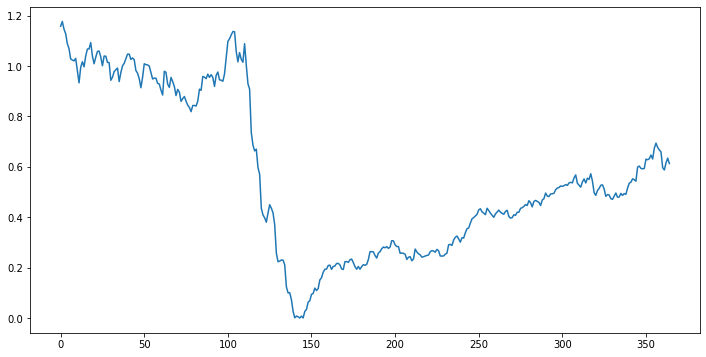

In [97]:
plt.figure(figsize=(12,6))
plt.plot(range(0, curve_length), np.array(encoded_[351*curve_length:352*curve_length]))

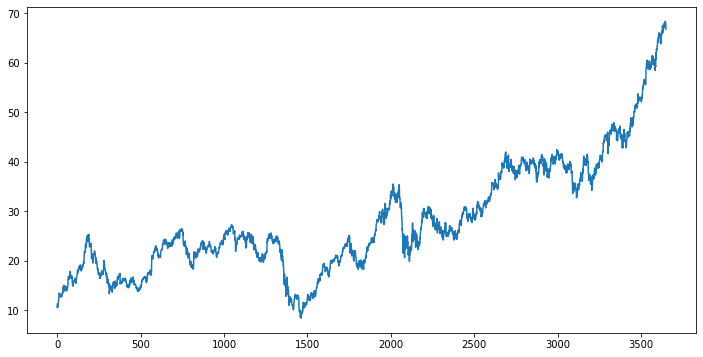

In [60]:
plt.figure(figsize=(12,6))
plt.plot(np.array(df.iloc[0, 1:]))

## Make the input and query files

In [72]:
df=pd.read_csv(d, delimiter='\t', header=None)
df = df.append(df_query, ignore_index = True)

In [73]:
ids = df[0]

In [74]:
scalers = train_scalers + test_scalers

In [ ]:
# Inverse transform the time series to bring them to their original values
time_series = [scalers[int(price/curve_length)].inverse_transform(encoded_[price:price+curve_length]) for price in range(0, len(encoded_), curve_length)]

In [30]:
time_series = np.array(time_series).reshape(len(time_series),len(time_series[0]))

In [78]:
df_input = pd.DataFrame(data=np.array(time_series[:-query_file_legnth]))
df_input.insert(0, column='ids', value=ids[:-query_file_legnth].values)

In [99]:
df_test = pd.DataFrame(data=np.array(time_series[-query_file_legnth:]))
df_test.insert(loc=0, column='ids', value=ids[-query_file_legnth:].values)

In [33]:
df_input.to_csv(od, index=False, header=False, sep ='\t')
df_test.to_csv(oq, index=False, header=False, sep ='\t')

In [ ]:
df_test.loc[df_test['ids'] == 'xl']

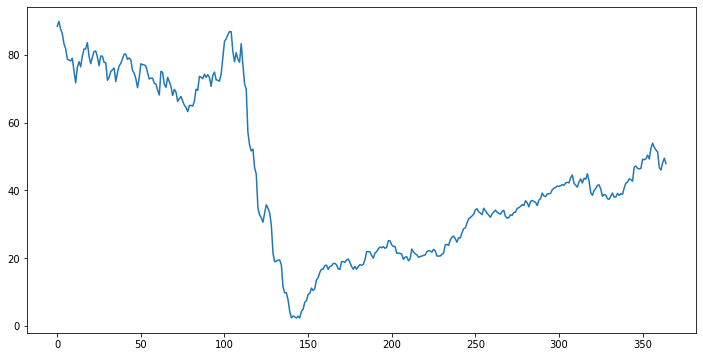

In [100]:
# Encoded time series
plt.figure(figsize=(12,6))
plt.plot(np.array(df_test.loc[df_test['ids'] == 'xl'].values[0][1:]))

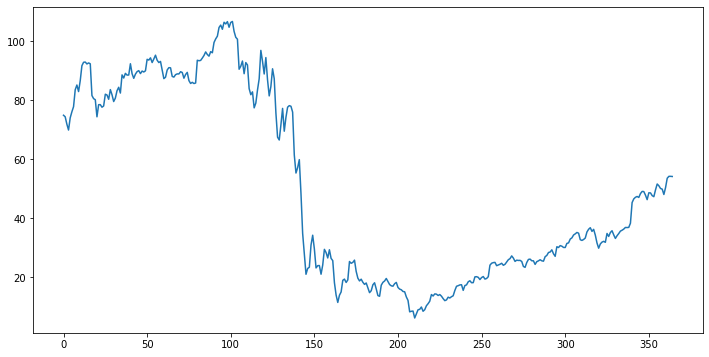

In [52]:
# Encoded time series
plt.figure(figsize=(12,6))
plt.plot(np.array(df_input.loc[df_input['ids'] == 'snv'].values[0][1:]))

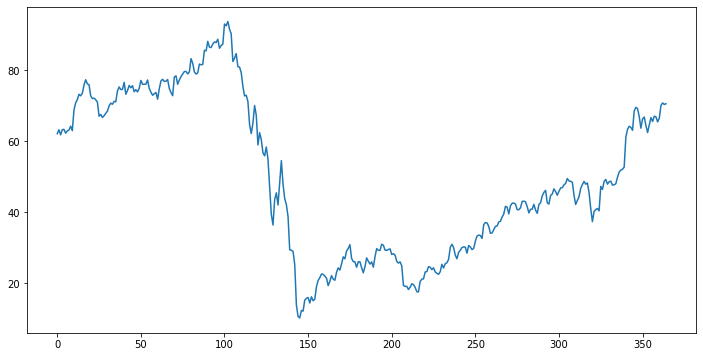

In [53]:
# Encoded time series
plt.figure(figsize=(12,6))
plt.plot(np.array(df_input.loc[df_input['ids'] == 'sti'].values[0][1:]))

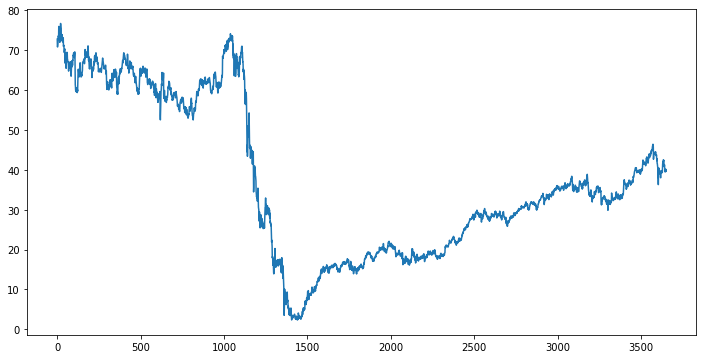

In [48]:
plt.figure(figsize=(12,6))
plt.plot(np.array(df.loc[df[0] == 'xl'].values[0][1:]))

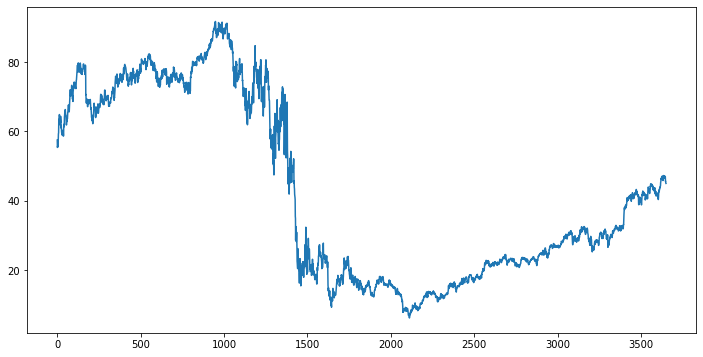

In [49]:
plt.figure(figsize=(12,6))
plt.plot(np.array(df.loc[df[0] == 'snv'].values[0][1:]))

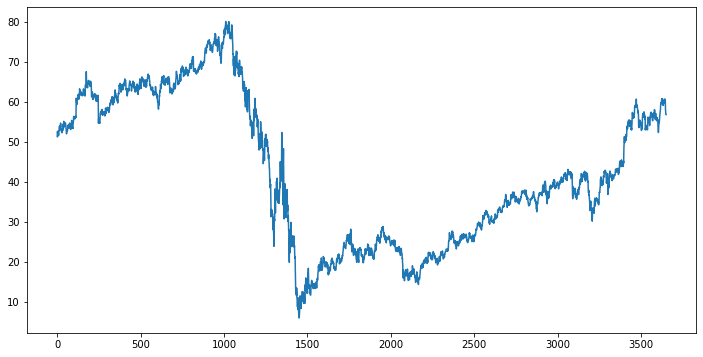

In [50]:
plt.figure(figsize=(12,6))
plt.plot(np.array(df.loc[df[0] == 'sti'].values[0][1:]))